Sample of processed data:
     patient_age  gender_encoded  financial_encoded  severity  entry_hour  \
568           48               2                  2         3         7.0   
271           67               1                  0         5         7.0   
614           73               1                  0         3         8.0   
253           42               0                  3         3         8.0   
707           67               0                  2         3         8.0   

     queue_load  queue_position  time_since_last  wait_time  
568           2               1              0.0  36.350000  
271           2               2              0.0  49.933333  
614         117               1              0.0  45.533333  
253         117               2              0.0  57.366667  
707         117               3              0.0  17.950000  

Wait Time Statistics (before log transform):
count    723.000000
mean      28.983356
std       15.046396
min        1.533333
25%       16.

/var/folders/63/gfgyqz0s19d0np85bch0z7k00000gn/T/ipykernel_95114/1891237193.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['entry_minutes'] = df['entry_time'].apply(time_to_minutes)



Best Parameters: {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 1000}
XGBoost RMSE: 16.02 minutes

Feature Importance (XGBoost):
patient_age: 0.1122
gender_encoded: 0.0989
financial_encoded: 0.0653
severity: 0.0867
entry_hour: 0.2788
queue_load: 0.2200
queue_position: 0.1382
time_since_last: 0.0000
Predicted Wait Time: 23.83 minutes
Predicted Wait Time: 31.56 minutes
Predicted Wait Time: 23.43 minutes
Predicted Wait Time: 24.21 minutes
Predicted Wait Time: 25.19 minutes


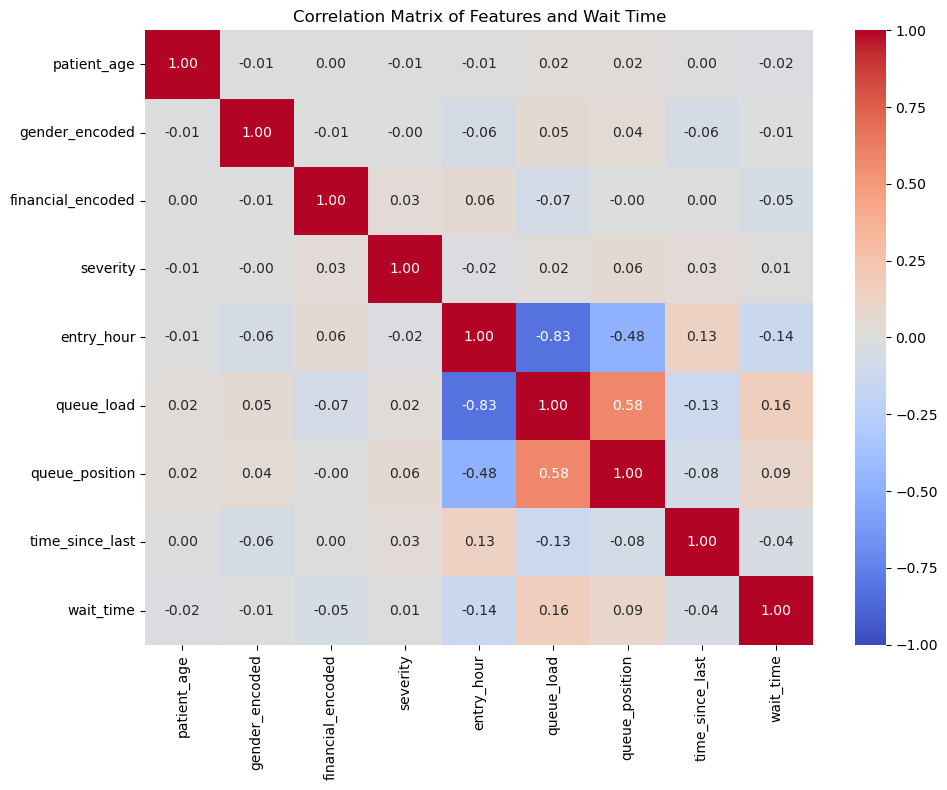

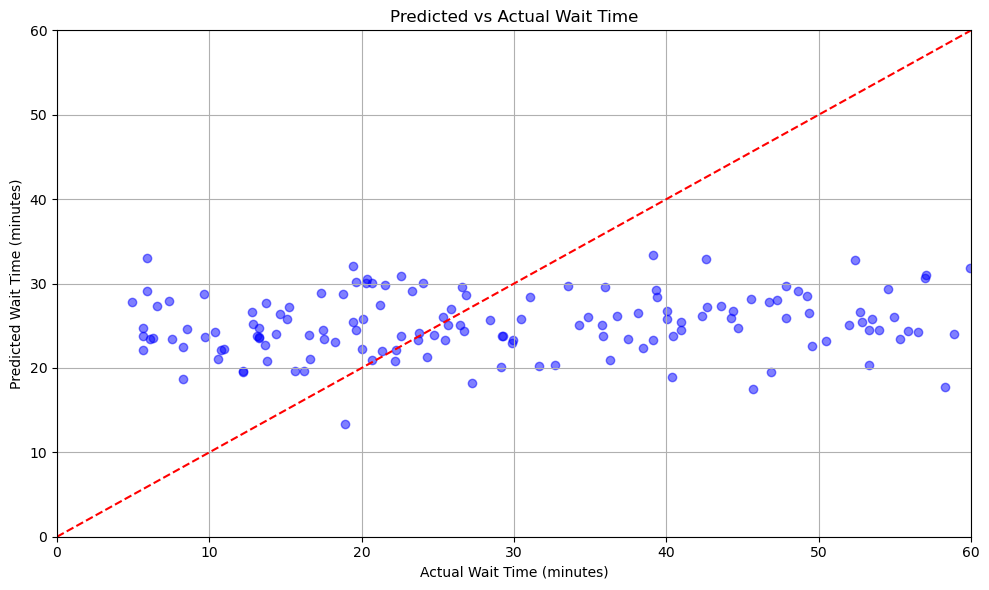

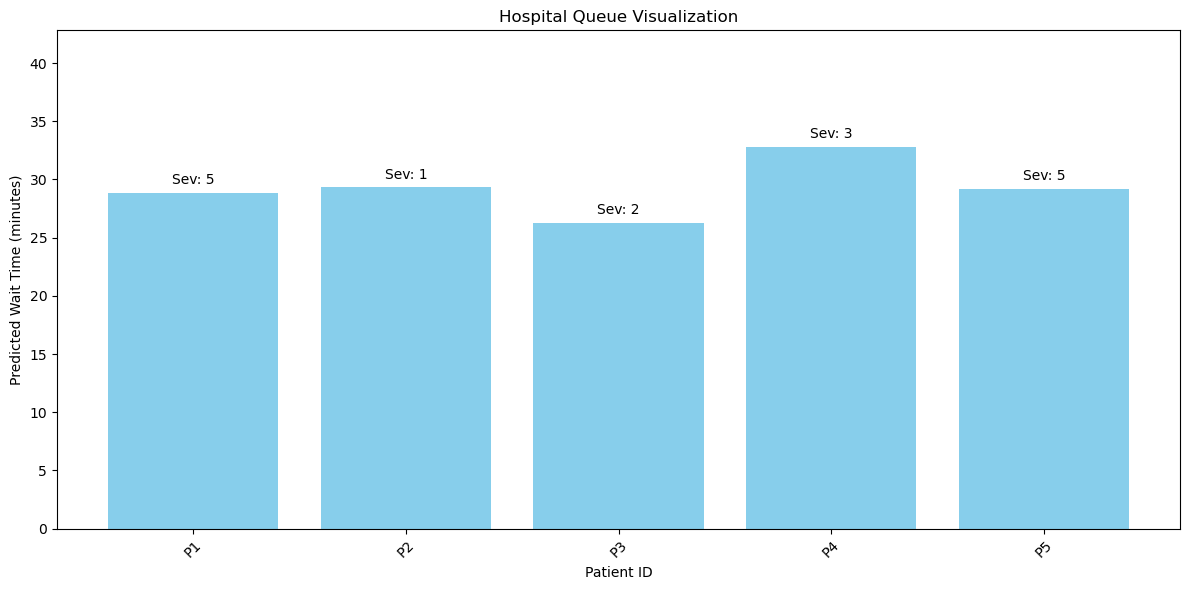


Queue Details:
  patient_id                            condition entry_time  queue_position  \
0         P1    Acute Myocardial Infarction (AMI)   08:45:00               1   
1         P2           Preventative Care Measures   08:46:00               2   
2         P3  Blood clot prevention and treatment   08:47:00               3   
3         P4   Emergency Department (ED) Measures   08:48:00               4   
4         P5    Acute Myocardial Infarction (AMI)   08:49:00               5   

   predicted_wait_time  
0            28.833439  
1            29.311768  
2            26.253222  
3            32.816525  
4            29.172579  


In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (Excel file)
file_path = '/Users/reinamercy/wait-time-prediction/dseb/mock_up_patient_data.xlsx'
data = pd.read_excel(file_path)

# Select relevant columns
df = data[['patient_id', 'patient_age', 'patient_gender', 'financial_class', 
           'condition', 'entry_time', 'post-consultation_time']]

# Function to convert time string to minutes since midnight
def time_to_minutes(time_str):
    if isinstance(time_str, str):
        time_obj = datetime.strptime(time_str, '%H:%M:%S')
    else:
        time_obj = datetime.strptime(time_str.strftime('%H:%M:%S'), '%H:%M:%S')
    return time_obj.hour * 60 + time_obj.minute + time_obj.second / 60

# Calculate wait time
df['entry_minutes'] = df['entry_time'].apply(time_to_minutes)
df['post_consultation_minutes'] = df['post-consultation_time'].apply(time_to_minutes)
df['wait_time'] = df['post_consultation_minutes'] - df['entry_minutes']

# Handle negative wait times and outliers
df.loc[df['wait_time'] < 0, 'wait_time'] = np.nan
df = df.dropna(subset=['wait_time'])
df = df[df['wait_time'] <= 60]  # Cap at 1 hour

# Feature engineering
df['entry_hour'] = df['entry_minutes'] // 60
df['queue_load'] = df.groupby('entry_hour')['patient_id'].transform('count')

# Severity scores
severity_scores = {
    'Acute Myocardial Infarction (AMI)': 5,
    'Emergency Department (ED) Measures': 3,
    'Blood clot prevention and treatment': 2,
    'Preventative Care Measures': 1
}
df['severity'] = df['condition'].map(severity_scores)

# New features
df = df.sort_values('entry_minutes')
df['queue_position'] = df.groupby('entry_hour').cumcount() + 1
df['prev_post_consultation'] = df['post_consultation_minutes'].shift(1).fillna(df['entry_minutes'].min())
df['time_since_last'] = df['entry_minutes'] - df['prev_post_consultation']
df['time_since_last'] = df['time_since_last'].clip(lower=0)

# Encode categorical variables
le_gender = LabelEncoder()
le_financial = LabelEncoder()
df['gender_encoded'] = le_gender.fit_transform(df['patient_gender'])
df['financial_encoded'] = le_financial.fit_transform(df['financial_class'])

# Features and target (log transform wait_time)
features = ['patient_age', 'gender_encoded', 'financial_encoded', 'severity', 
            'entry_hour', 'queue_load', 'queue_position', 'time_since_last']
X = df[features]
y = np.log1p(df['wait_time'])  # Log transform

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Diagnostics
print("Sample of processed data:")
print(df[features + ['wait_time']].head())
print("\nWait Time Statistics (before log transform):")
print(df['wait_time'].describe())
print("\nLog Wait Time Statistics:")
print(pd.Series(y).describe())
print("\nCorrelation with Log Wait Time:")
print(pd.concat([X, y.rename('log_wait_time')], axis=1).corr()['log_wait_time'].sort_values())

# --- XGBoost Model with Grid Search ---
xgb_base = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 7, 10]
}
grid_search = GridSearchCV(xgb_base, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
xgb_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

# Predict and evaluate (inverse log transform for RMSE)
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test_original, y_pred))
print(f"XGBoost RMSE: {rmse_xgb:.2f} minutes")

# Feature importance
importances = xgb_model.feature_importances_
print("\nFeature Importance (XGBoost):")
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

# Prediction function
def predict_wait_time(patient_age, gender, financial_class, condition, entry_time, queue_load, queue_position, time_since_last):
    input_data = pd.DataFrame({
        'patient_age': [patient_age],
        'patient_gender': [gender],
        'financial_class': [financial_class],
        'condition': [condition],
        'entry_time': [entry_time],
        'queue_load': [queue_load],
        'queue_position': [queue_position],
        'time_since_last': [time_since_last]
    })
    input_data['entry_minutes'] = input_data['entry_time'].apply(time_to_minutes)
    input_data['entry_hour'] = input_data['entry_minutes'] // 60
    input_data['severity'] = input_data['condition'].map(severity_scores)
    input_data['gender_encoded'] = le_gender.transform(input_data['patient_gender'])
    input_data['financial_encoded'] = le_financial.transform(input_data['financial_class'])
    X_input = input_data[features]
    pred_log = xgb_model.predict(X_input)
    return np.expm1(pred_log)[0]

# Example usage
example_wait_time = predict_wait_time(45, 'male', 'insurance', 'Emergency Department (ED) Measures', '14:30:00', 5, 3, 10.0)
print(f"Predicted Wait Time: {example_wait_time:.2f} minutes")

wait_time = predict_wait_time(72, 'female', 'medicare', 'Acute Myocardial Infarction (AMI)', '08:45:00', 8, 5, 15.0)
print(f"Predicted Wait Time: {wait_time:.2f} minutes")

wait_time = predict_wait_time(25, 'male', 'insurance', 'Preventative Care Measures', '14:15:00', 3, 2, 5.0)
print(f"Predicted Wait Time: {wait_time:.2f} minutes")

wait_time = predict_wait_time(50, 'unidentified', 'corporate', 'Blood clot prevention and treatment', '18:30:00', 6, 4, 20.0)
print(f"Predicted Wait Time: {wait_time:.2f} minutes")

wait_time = predict_wait_time(17, 'female', 'HMO', 'Emergency Department (ED) Measures', '23:00:00', 2, 1, 10.0)
print(f"Predicted Wait Time: {wait_time:.2f} minutes")

# Simulate queue (fixed column name from 'position' to 'queue_position')
queue = [
    {"patient_id": "P1", "age": 72, "gender": "female", "financial": "medicare", "condition": "Acute Myocardial Infarction (AMI)", "entry_time": "08:45:00", "queue_load": 8, "queue_position": 1, "time_since_last": 15.0},
    {"patient_id": "P2", "age": 25, "gender": "male", "financial": "insurance", "condition": "Preventative Care Measures", "entry_time": "08:46:00", "queue_load": 8, "queue_position": 2, "time_since_last": 15.0},
    {"patient_id": "P3", "age": 50, "gender": "unidentified", "financial": "corporate", "condition": "Blood clot prevention and treatment", "entry_time": "08:47:00", "queue_load": 8, "queue_position": 3, "time_since_last": 15.0},
    {"patient_id": "P4", "age": 17, "gender": "female", "financial": "HMO", "condition": "Emergency Department (ED) Measures", "entry_time": "08:48:00", "queue_load": 8, "queue_position": 4, "time_since_last": 15.0},
    {"patient_id": "P5", "age": 35, "gender": "male", "financial": "insurance", "condition": "Acute Myocardial Infarction (AMI)", "entry_time": "08:49:00", "queue_load": 8, "queue_position": 5, "time_since_last": 15.0}
]

queue_df = pd.DataFrame(queue)
queue_df['predicted_wait_time'] = queue_df.apply(
    lambda row: predict_wait_time(row['age'], row['gender'], row['financial'], row['condition'], 
                                  row['entry_time'], row['queue_load'], row['queue_position'], row['time_since_last']),
    axis=1
)

# --- Visualizations ---
# 1. Correlation Matrix
plt.figure(figsize=(10, 8))
corr_matrix = pd.concat([X, df['wait_time']], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features and Wait Time')
plt.tight_layout()
plt.show()

# 2. Predicted vs Actual Wait Time Graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5, color='blue')
plt.plot([0, 60], [0, 60], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Wait Time (minutes)')
plt.ylabel('Predicted Wait Time (minutes)')
plt.title('Predicted vs Actual Wait Time')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Queue Visualization
plt.figure(figsize=(12, 6))
bars = plt.bar(queue_df['patient_id'], queue_df['predicted_wait_time'], color='skyblue')
for bar, severity in zip(bars, queue_df['condition'].map(severity_scores)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'Sev: {severity}', 
             ha='center', va='bottom', fontsize=10)
plt.xlabel('Patient ID')
plt.ylabel('Predicted Wait Time (minutes)')
plt.title('Hospital Queue Visualization')
plt.xticks(rotation=45)
plt.ylim(0, max(queue_df['predicted_wait_time']) + 10)
plt.tight_layout()
plt.show()

# Print queue details (fixed column name)
print("\nQueue Details:")
print(queue_df[['patient_id', 'condition', 'entry_time', 'queue_position', 'predicted_wait_time']])